- Check for Colab Env
> if we are in colab env we need to get the data + scripts from github or somewhere

In [1]:
import os
if "COLAB_GPU" in os.environ:
    _useMultiProcessing = False
    os.system("git clone https://github.com/zaxo7/UNet-Playground.git")
    os.chdir("/content/UNet-Playground/")
else:
    _useMultiProcessing = True
    
if "PAPERSPACE_FQDN" in os.environ:
    !apt update
    !apt install libgl1 -y
    !pip install opencv-python 
    !git pull



Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease                     
Get:3 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [874 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1816 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [1174 kB]33m
Get:7 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [27.5 kB]
Get:8 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]      
Get:9 http://archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [2245 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal-updates/multiverse amd64 Packages [30.2 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal-updates/universe amd64 Packages [1161 kB]
Get:12 http://archive.ubuntu.com/ubuntu focal-updates/restricted amd64 Packages

- enable module autoreload and fix an import bug

In [1]:
%load_ext autoreload
%autoreload 2

import sys,os
sys.path.append(os.getcwd() + '/scripts')

- import the scripts and data

In [4]:
from scripts import data, model
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import pandas as pd
import time
from scripts.DataGenerator import DataGenerator

- model parameters

In [5]:
_batch_size = 8
_epochs = 50
_workers = 8
_model_name = f'tversky_100'
images_per_epoch = 1000
train_steps = images_per_epoch//_batch_size
#validation_steps = len(test_img_tile_files)//_batch_size

Train = True

In [7]:
database = "data2"


train_img_tile_files = sorted(glob.glob(f'{database}/train/tiles/*.jpg'))
train_mask_tile_label_files = sorted(glob.glob(f'{database}/train/mask/tiles/*.jpg'))
train_edge_tile_label_files = sorted(glob.glob(f'{database}/train/edge/tiles/*.jpg'))

database = "data"

test_img_tile_files = sorted(glob.glob(f'{database}/test/tiles/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database}/test/mask/tiles/*.jpg'))
test_edge_tile_label_files = sorted(glob.glob(f'{database}/test/edge/tiles/*.jpg'))

train_gen = DataGenerator(train_img_tile_files, train_mask_tile_label_files, train_mask_tile_label_files, _batch_size, skip_empty = True)

test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, test_mask_tile_label_files, _batch_size, skip_empty = True, augment=False)



skipping empty images with keep probability of 0.05
before skip we have 34120 images


100%|██████████| 34120/34120 [06:09<00:00, 92.44it/s] 


after skip we have 34119 images
skipping empty images with keep probability of 0.05
before skip we have 1834 images


100%|██████████| 1834/1834 [00:07<00:00, 237.18it/s]

after skip we have 1321 images


- load weights and compile it

In [13]:
print(f"loading model {_model_name}")
#unet.load_weights(f"models/{_model_name}_best.h5")

#unet.save('./tmp_model',save_format='tf')

objects = {
    "tversky_loss":model.tversky_loss,
    "mean_iou": model.mean_iou,
    "dsc":model.dsc,
    "tversky":model.tversky,
    "tversky_b":model.tversky_b,
    "acc": tf.keras.metrics.Accuracy,
    "tversky_loss_b": model.tversky_loss_b
}



unet = tf.keras.models.load_model(f'./models/{_model_name}', custom_objects=objects)

print(len(unet.layers))

layers = []
#freeze the layers
#freeze the all the layers
#layers = range(0, 66)
#freeze the edge layer
layers = [-1]
for ind in layers:
    #print(f"freezing layer {unet.layers[ind].name}")
    unet.layers[ind].trainable = False

unet.compile(optimizer="adam",
             loss=model.tversky_loss,
             loss_weights={"mask": 1.0, "edge": 0},
             metrics={'mask': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc'], 
                      'edge': [model.mean_iou, model.dsc, model.tversky, model.tversky_b, 'acc']})




layers = [(layer.name, layer.output.shape, layer.trainable) for layer in unet.layers]
df = pd.DataFrame(layers, columns=['Layer Name', 'Output Shape', 'Layer Trainable'])

print(df.to_string())

#unet.summary()

loading model tversky_100
66
                Layer Name          Output Shape  Layer Trainable
0                  input_1   (None, 188, 188, 3)             True
1                   conv2d  (None, 186, 186, 96)             True
2      batch_normalization  (None, 186, 186, 96)             True
3               activation  (None, 186, 186, 96)             True
4                 conv2d_1  (None, 186, 186, 32)             True
5    batch_normalization_1  (None, 186, 186, 32)             True
6             activation_1  (None, 186, 186, 32)             True
7                 conv2d_2  (None, 184, 184, 32)             True
8    batch_normalization_2  (None, 184, 184, 32)             True
9             activation_2  (None, 184, 184, 32)             True
10           max_pooling2d    (None, 92, 92, 32)             True
11                conv2d_3    (None, 90, 90, 64)             True
12   batch_normalization_3    (None, 90, 90, 64)             True
13            activation_3    (None, 90, 90, 64

- evaluate the model before train

In [112]:
old_database = database
database = "data"

test_img_tile_files = sorted(glob.glob(f'{database}/test/tiles/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database}/test/mask/tiles/*.jpg'))
test_edge_tile_label_files = sorted(glob.glob(f'{database}/test/edge/tiles/*.jpg'))

old_test_gen = test_gen
test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, test_edge_tile_label_files, _batch_size, skip_empty = False, augment=False)

unet.evaluate(test_gen)

database = old_database
test_gen = old_test_gen

229/229 [==============================] - 18s 79ms/step - loss: 0.1105 - mask_loss: 0.1105 - edge_loss: 0.3724 - mask_mean_iou: 0.5023 - mask_dsc: 0.8879 - mask_tversky: 0.8895 - mask_tversky_b: 0.8947 - mask_acc: 0.9507 - edge_mean_iou: 0.2217 - edge_dsc: 0.5899 - edge_tversky: 0.6276 - edge_tversky_b: 0.6277 - edge_acc: 0.9423


- Train the model

In [15]:
if Train:
    history = unet.fit(train_gen, 
            epochs=_epochs, 
            validation_data=test_gen, 
            steps_per_epoch=train_steps,
            max_queue_size=2*_workers,
            use_multiprocessing=True,
            workers=_workers,
            verbose=1,
            callbacks=model.get_callbacks(_model_name + "_data2_data2_50_1_0_edge_freezed_" + str(time.time()) + "_adv"))

Epoch 1/50
125/125 [==============================] - ETA: 0s - loss: 0.0611 - mask_loss: 0.0611 - edge_loss: 0.7739 - mask_mean_iou: 0.7519 - mask_dsc: 0.9314 - mask_tversky: 0.9389 - mask_tversky_b: 0.9392 - mask_acc: 0.9602 - edge_mean_iou: 0.1447 - edge_dsc: 0.2759 - edge_tversky: 0.2261 - edge_tversky_b: 0.2259 - edge_acc: 0.6575
Epoch 00001: val_loss improved from inf to 0.03259, saving model to models/tversky_100_data2_data2_50_1_0_edge_freezed_1653299353.6767304_adv_best.h5
125/125 [==============================] - 129s 1s/step - loss: 0.0611 - mask_loss: 0.0611 - edge_loss: 0.7739 - mask_mean_iou: 0.7519 - mask_dsc: 0.9314 - mask_tversky: 0.9389 - mask_tversky_b: 0.9392 - mask_acc: 0.9602 - edge_mean_iou: 0.1447 - edge_dsc: 0.2759 - edge_tversky: 0.2261 - edge_tversky_b: 0.2259 - edge_acc: 0.6575 - val_loss: 0.0326 - val_mask_loss: 0.0326 - val_edge_loss: 0.8224 - val_mask_mean_iou: 0.7963 - val_mask_dsc: 0.9561 - val_mask_tversky: 0.9674 - val_mask_tversky_b: 0.9681 - val_ma

- save the training log 

In [10]:
#save the training log into a file
import json
my_dict = {'a':11,'b':22,'c':33}
with open(f"models/{_model_name}_log.json", "a+") as fp:
    json.dump(history.history,fp)

# Opening JSON file
with open(f"models/{_model_name}_log.json") as fp:
    # returns JSON object as
    # a dictionary
    loaded_hist = json.load(fp)


JSONDecodeError: Extra data: line 1 column 52736 (char 52735)

- evaluate model after training

In [18]:
old_database = database
database = "data"

test_img_tile_files = sorted(glob.glob(f'{database}/test/tiles/*.jpg'))
test_mask_tile_label_files = sorted(glob.glob(f'{database}/test/mask/tiles/*.jpg'))
test_edge_tile_label_files = sorted(glob.glob(f'{database}/test/edge/tiles/*.jpg'))

old_test_gen = test_gen
test_gen = DataGenerator(test_img_tile_files, test_mask_tile_label_files, test_edge_tile_label_files, _batch_size, skip_empty = False, augment=False)

unet.evaluate(test_gen)

database = old_database
test_gen = old_test_gen

229/229 [==============================] - 12s 54ms/step - loss: 0.0301 - mask_loss: 0.0301 - edge_loss: 0.3551 - mask_mean_iou: 0.5567 - mask_dsc: 0.9675 - mask_tversky: 0.9699 - mask_tversky_b: 0.9700 - mask_acc: 0.9777 - edge_mean_iou: 0.2359 - edge_dsc: 0.6204 - edge_tversky: 0.6449 - edge_tversky_b: 0.6462 - edge_acc: 0.9493


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


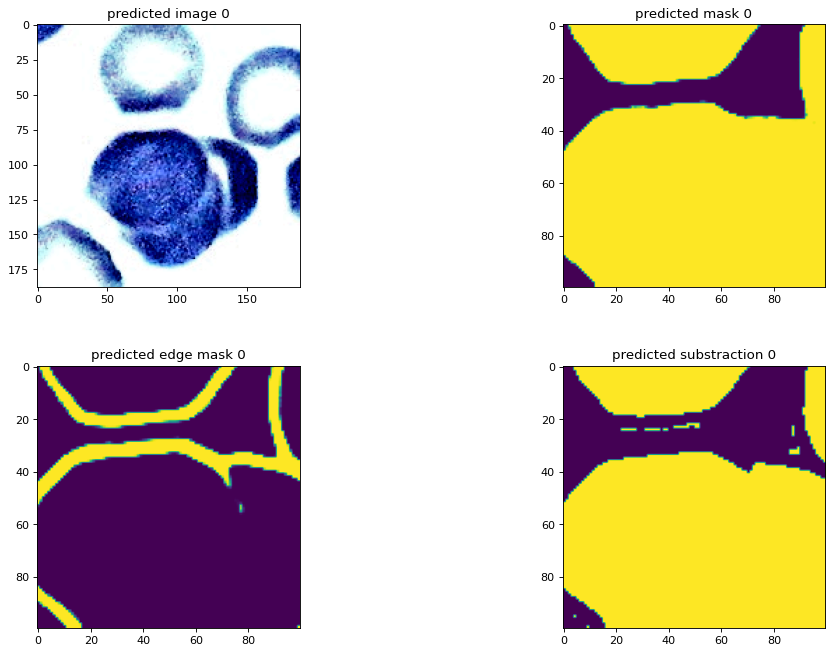

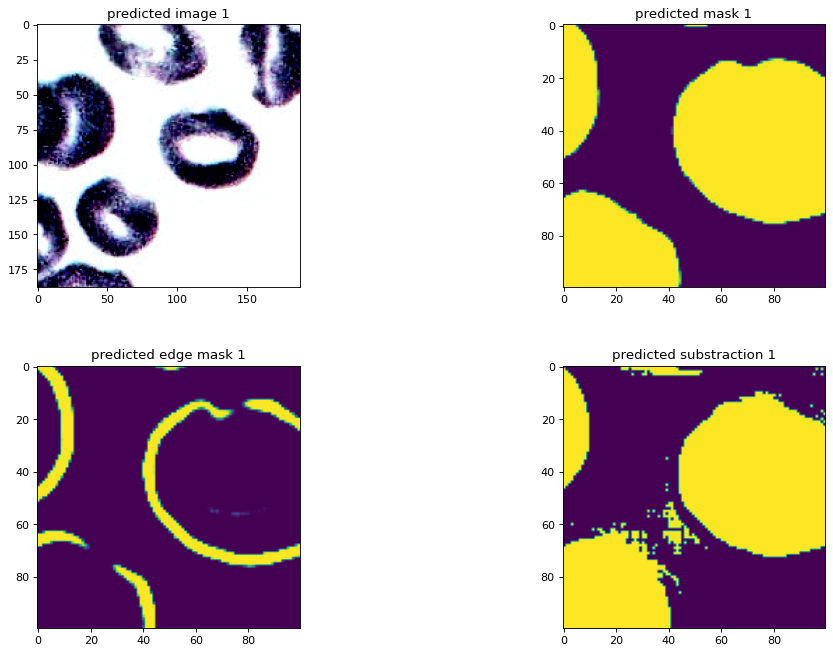

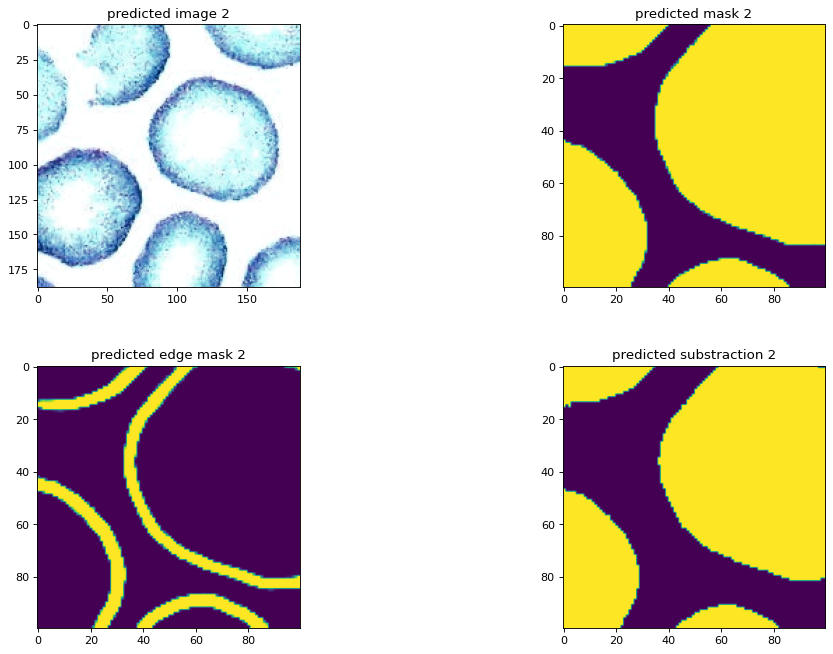

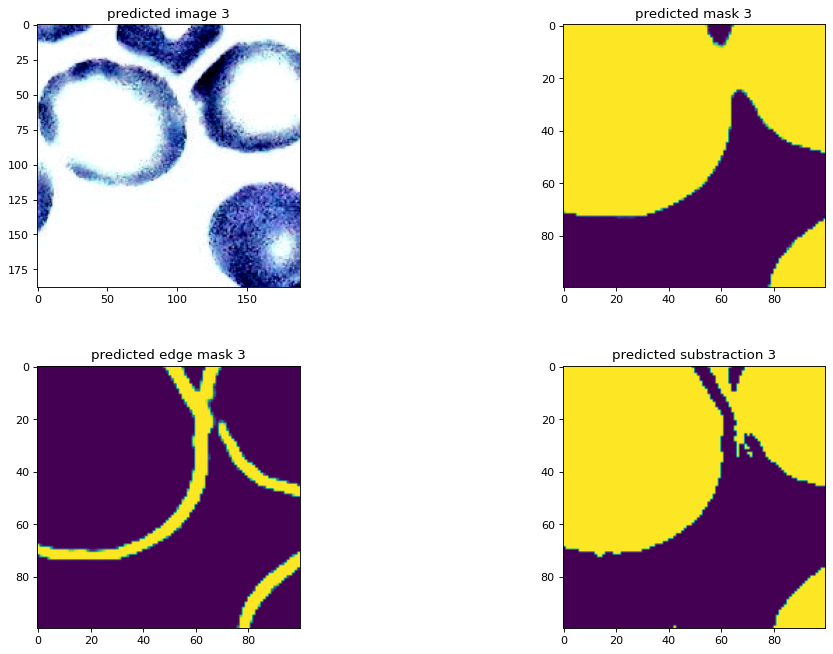

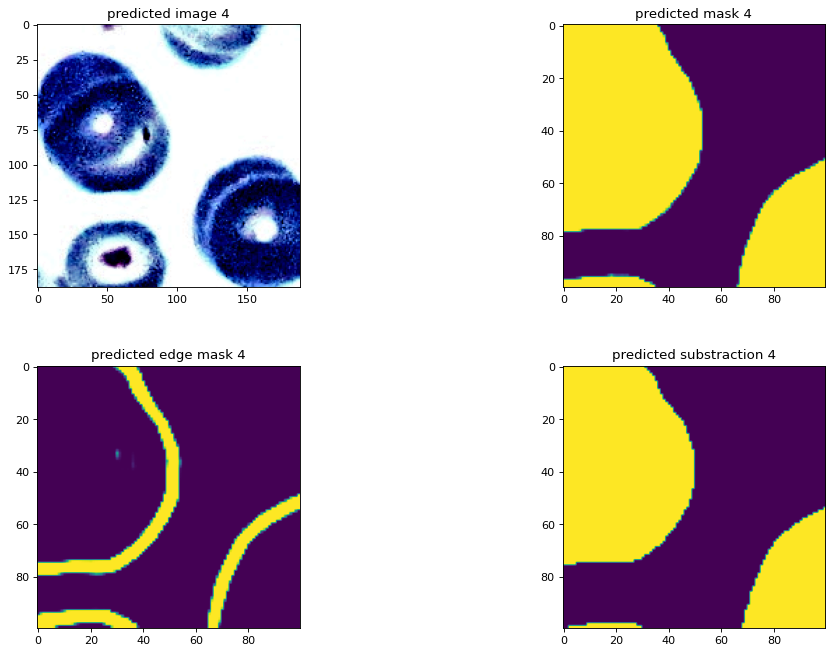

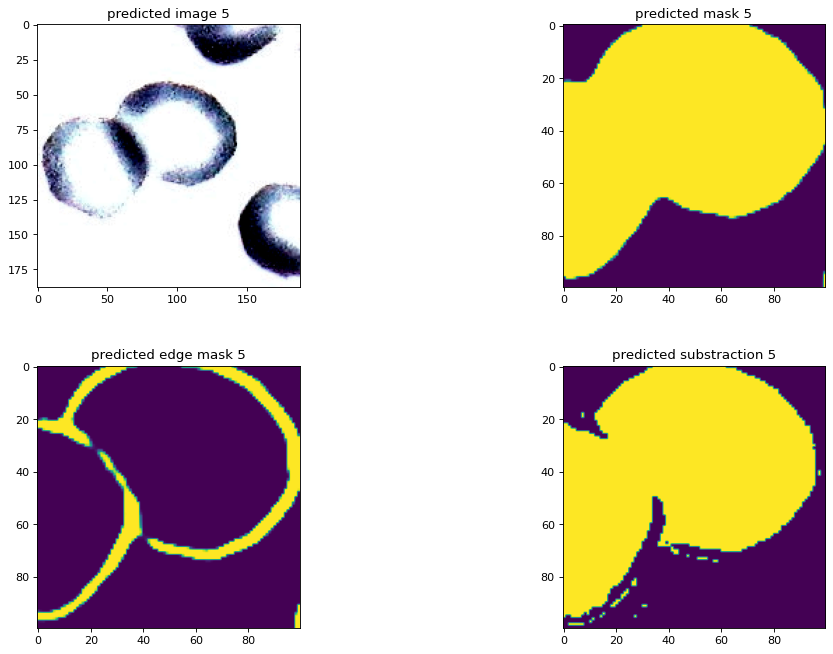

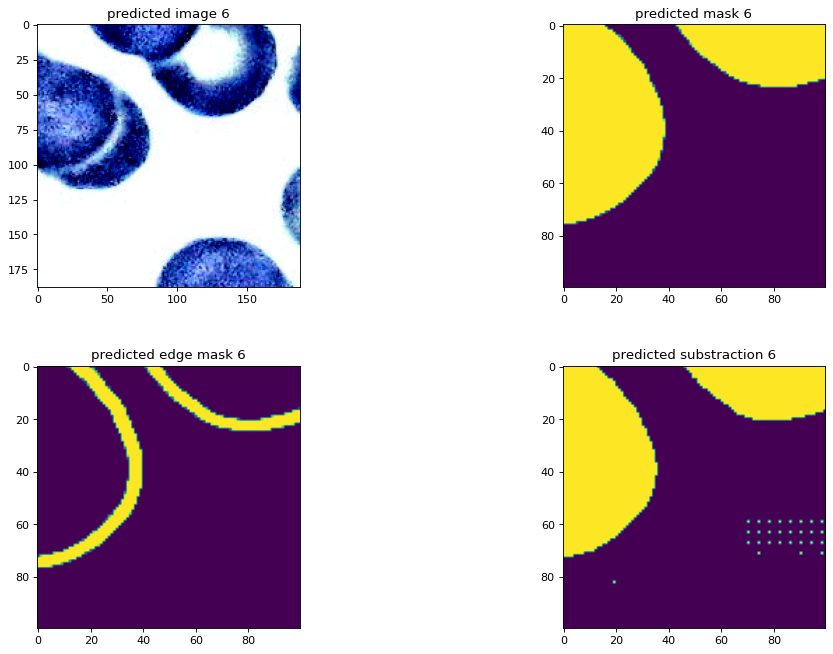

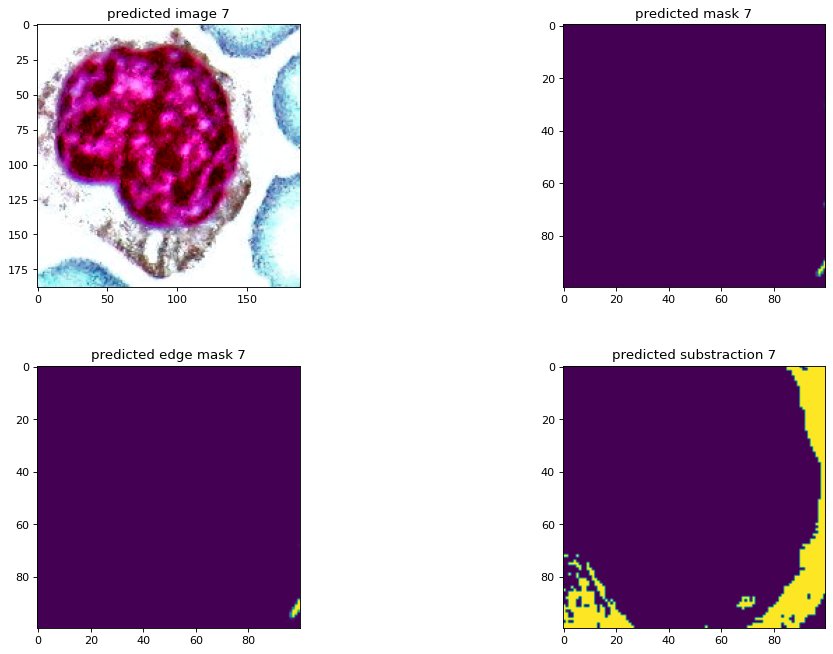

In [17]:

images, (masks, edges) = train_gen.__getitem__(1165)

#data.plot_ime(images, masks, edges)

prediction = unet.predict(images)

#prediction = np.squeeze(prediction)

data.plot_ime(images, prediction[0], prediction[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


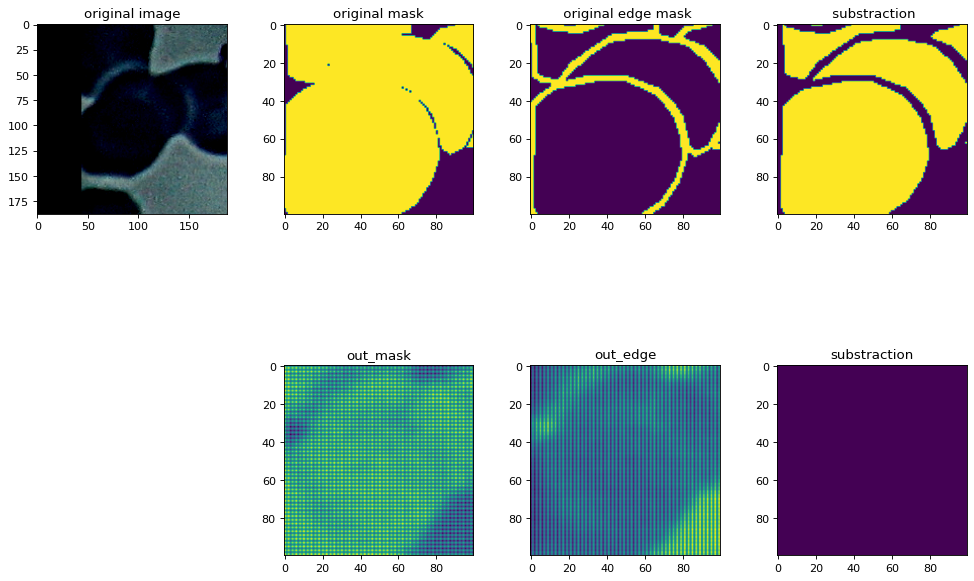

In [ ]:
fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original image")
ax.imshow(img[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("original mask")
ax.imshow(mask)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" original edge mask")
ax.imshow(edge)
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title(" substraction")
ax.imshow((mask - edge) > 0)


fig_num = fig_num + 2
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_mask")
ax.imshow(prediction[0])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("out_edge")
ax.imshow(prediction[1])
fig_num = fig_num + 1
ax = fig.add_subplot(2, 4, fig_num)
ax.set_title("substraction")
ax.imshow((prediction[0] - prediction[1]) > 0)




- predict full image

In [ ]:
images, masks, edges = model.predictFullImage(unet,
                          data.load_data_na(test_img_files),
                        padding=100,
                        input_size=188,
                        output_size=100,
                        normalize_output = False)

In [ ]:
data.plot_ime(images,
              masks,
              edges,
              figSize=(25,15))

## model training data plot

In [ ]:
hist = history.history

lines = 4
columns = 3

fig = plt.figure(figsize=(20, 20), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask accuracy")
ax.plot(hist['mask_acc'], label="Training")
ax.plot(hist['val_mask_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge mask accuracy")
ax.plot(hist['edge_acc'], label="Training")
ax.plot(hist['val_edge_acc'], label="Validation")
ax.legend()
fig_num = fig_num + 2
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask loss")
ax.plot(hist['mask_loss'], label="Training")
ax.plot(hist['val_mask_loss'], label="Validation")
ax.legend()
fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge loss")
ax.plot(hist['edge_loss'], label="Training")
ax.plot(hist['val_edge_loss'], label="Validation")
ax.legend()

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("global loss")
ax.plot(hist['loss'], label="Training")
ax.plot(hist['val_loss'], label="Validation")
ax.legend()


fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("mask metrics")
ax.plot(hist['mask_dsc'], label="dsc")
ax.plot(hist['mask_mean_iou'], label="mean iou")
ax.plot(hist['mask_tversky'], label="tversky")
ax.plot(hist['mask_acc'], label="accuracy")

ax.set_title("mask metrics")
ax.plot(hist['val_mask_dsc'], label="val_dsc")
ax.plot(hist['val_mask_mean_iou'], label="val_mean iou")
ax.plot(hist['val_mask_tversky'], label="val_tversky")
ax.plot(hist['val_mask_acc'], label="val_accuracy")

fig_num = fig_num + 1
ax = fig.add_subplot(lines, columns, fig_num)
ax.set_title("edge metrics")
ax.plot(hist['edge_dsc'], label="dsc")
ax.plot(hist['edge_mean_iou'], label="mean iou")
ax.plot(hist['edge_tversky'], label="tversky")
ax.plot(hist['edge_acc'], label="accuracy")

ax.set_title("edge metrics")
ax.plot(hist['val_edge_dsc'], label="val_dsc")
ax.plot(hist['val_edge_mean_iou'], label="val_mean iou")
ax.plot(hist['val_edge_tversky'], label="val_tversky")
ax.plot(hist['val_edge_acc'], label="val_accuracy")
ax.legend()

## For Debugging
- show in between layers output

In [17]:
ind = np.random.randint(0, 32, 1)[0]

_pool1 = pool1[:-1,:-1,ind]
_pool2 = pool2[:-1,:-1,ind]
_pool3 = pool3[:-1,:-1,ind]
_down4 = down4[:-1,:-1,ind]
_up1 = up1[:-1,:-1,ind]
_up2 = up2[:-1,:-1,ind]
_up3 = up3[:-1,:-1,ind]

fig = plt.figure(figsize=(15, 10), dpi=80)
fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig_num = 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_mask")
ax.imshow(out_mask)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("out_edge")
ax.imshow(out_edge)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool1")
ax.imshow(_pool1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool2")
ax.imshow(_pool2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("pool3")
ax.imshow(_pool3)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("down4")
ax.imshow(_down4)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up1")
ax.imshow(_up1)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up2")
ax.imshow(_up2)
fig_num = fig_num + 1
ax = fig.add_subplot(3, 3, fig_num)
ax.set_title("up3")
ax.imshow(_up3)

NameError: name 'pool1' is not defined

- function to plot and array of images of shape (width, height, n_images)

In [ ]:
def picshow(img, title):
    num = img.shape[2]
    imgs_per_line = 4
    ax = num//imgs_per_line + 1
    ay = imgs_per_line
    fig =plt.figure(figsize=(30, num//imgs_per_line * 10))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    for i in range(1,num + 1):
        sub = fig.add_subplot(ax,ay,i)
        sub.set_title(f"{title} {i}")
        sub.imshow(img[:-1,:-1,i - 1])
    plt.show()
    



In [ ]:
picshow(pool1, 'pool1 ')
picshow(pool2, 'pool2 ')
picshow(pool3, 'pool3 ')
picshow(down4, 'down4 ')
picshow(up1, 'up1 ')
picshow(up2, 'up2 ')
picshow(up3, 'up3 ')